#Tourism hierarachy
https://github.com/erykml/medium_articles/blob/master/data/tourism.csv



The data set contains the quarterly number of trips to Australia between 1998 and 2016

**url**  https://towardsdatascience.com/introduction-to-hierarchical-time-series-forecasting-part-ii-e73dfd3de86b

**date_of_publish** Mar 14 2021


**python package_name** scikit-hts pmdarima

github_page 

In [1]:
!pip install pmdarima
!pip install scikit-hts==0.5.3

     |████████████████████████████████| 1.5MB 24.8MB/s 
     |████████████████████████████████| 9.5MB 51.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 81kB 10.2MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [5]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)



In [6]:
!ls -al
!rm 'tourism.csv'

total 16
drwxr-xr-x 1 root root 4096 May  6 13:44 .
drwxr-xr-x 1 root root 4096 May 26 19:35 ..
drwxr-xr-x 4 root root 4096 May  6 13:43 .config
drwxr-xr-x 1 root root 4096 May  6 13:44 sample_data
rm: cannot remove 'tourism.csv': No such file or directory


In [7]:
%config InlineBackend.figure_format = 'retina'

In [8]:
from google.colab import files
uploaded = files.upload()  

Saving tourism.csv to tourism.csv


In [9]:
import io
# load the data 
df = pd.read_csv(io.BytesIO(uploaded['tourism.csv'])) \
       .drop(columns=["Unnamed: 0"])
# df = pd.read_csv('tourism.csv') \
#        .drop(columns=["Unnamed: 0"])

In [10]:
# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

df.head()

,quarter,region,state,trips,state_region
0,1998-01-01,Adelaide,SA,658.553895,SA_Adelaide
1,1998-01-01,Adelaide_Hills,SA,9.798630,SA_Adelaide_Hills
2,1998-01-01,Alice_Springs,NT,20.207638,NT_Alice_Springs
3,1998-01-01,Australias_Coral_Coast,WA,132.516409,WA_Australias_Coral_Coast
4,1998-01-01,Australias_Golden_Outback,WA,161.726948,WA_Australias_Golden_Outback


In [11]:
df.groupby("state")["region"].apply(set).to_frame()

,region
state,
ACT,{Canberra}
NSW,"{Capital_Country, Riverina, Central_NSW, North..."
NT,"{Barkly, Tasmania, Kakadu_Arnhem, North_West, ..."
QLD,"{Gold_Coast, Darling_Downs, Central_Queensland..."
SA,"{Flinders_Ranges_and_Outback, Limestone_Coast,..."
VIC,"{Wimmera, Melbourne, Spa_Country, Bendigo_Lodd..."
WA,"{Australias_South_West, Australias_Coral_Coast..."


In [12]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")

hierarchy_df.head()

Number of time series at the bottom level: 77
Number of time series at the middle level: 7


,ACT_Canberra,NSW_Blue_Mountains,NSW_Capital_Country,NSW_Central_Coast,NSW_Central_NSW,NSW_Hunter,NSW_New_England_North_West,NSW_North_Coast_NSW,NSW_Outback_NSW,NSW_Riverina,NSW_Snowy_Mountains,NSW_South_Coast,NSW_Sydney,NSW_The_Murray,NT_Alice_Springs,NT_Barkly,NT_Darwin,NT_East_Coast,NT_Hobart_and_the_South,NT_Kakadu_Arnhem,NT_Katherine_Daly,NT_Lasseter,"NT_Launceston,_Tamar_and_the_North",NT_MacDonnell,NT_North_West,NT_Tasmania,NT_Wilderness_West,QLD_Brisbane,QLD_Bundaberg,QLD_Central_Queensland,QLD_Darling_Downs,QLD_Fraser_Coast,QLD_Gold_Coast,QLD_Mackay,QLD_Northern,QLD_Outback,QLD_Sunshine_Coast,QLD_Tropical_North_Queensland,QLD_Whitsundays,SA_Adelaide,...,SA_Flinders_Ranges_and_Outback,SA_Kangaroo_Island,SA_Limestone_Coast,SA_Murraylands,SA_Riverland,SA_Yorke_Peninsula,VIC_Ballarat,VIC_Bendigo_Loddon,VIC_Central_Highlands,VIC_Central_Murray,VIC_Geelong,VIC_Gippsland,VIC_Goulburn,VIC_High_Country,VIC_Lakes,VIC_Macedon,VIC_Mallee,VIC_Melbourne,VIC_Melbourne_East,VIC_Murray_East,VIC_Peninsula,VIC_Phillip_Island,VIC_Spa_Country,VIC_Upper_Yarra,VIC_Western,VIC_Western_Grampians,VIC_Wimmera,WA_Australias_Coral_Coast,WA_Australias_Golden_Outback,WA_Australias_North_West,WA_Australias_South_West,WA_Experience_Perth,ACT,NSW,NT,QLD,SA,VIC,WA,total
quarter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01,551.001921,195.543180,261.808142,455.166849,424.395446,674.978457,329.838506,1342.301230,96.602651,215.268912,140.989157,1257.446550,2288.955629,356.500087,20.207638,18.465206,87.607295,148.855652,380.602050,18.359518,16.771762,10.086239,247.595226,9.951165,141.241141,751.631888,63.335097,1052.194495,122.914282,191.589276,259.086028,173.961068,827.045761,128.935651,226.112807,37.196194,742.602300,220.915346,60.226649,658.553895,...,112.097738,34.678300,212.982623,68.004076,89.511377,160.681637,182.239342,231.685977,88.907326,196.298722,255.444832,382.608956,153.398516,320.504579,211.835892,24.790891,182.084599,1578.548409,86.852958,22.317190,694.723679,364.043288,86.196006,102.791022,739.350975,86.996591,18.804743,132.516409,161.726948,120.775450,474.858729,751.211958,551.001921,8039.794795,1914.709878,4042.779858,1732.743704,6010.424491,1641.089495,23932.544141
1998-04-01,416.025623,200.408671,238.600029,343.476758,557.011570,791.887234,328.366005,1161.108602,120.648446,336.094921,166.586342,795.074559,1814.459479,312.291189,56.356223,7.510969,116.864811,106.221127,226.909579,52.845863,40.806116,34.845044,172.854001,4.707126,144.696445,534.181412,42.607076,950.414816,110.058311,288.445257,439.035287,129.738887,680.774502,131.950023,159.481069,107.999764,609.883333,253.097616,106.190848,449.853934,...,122.200254,9.057817,154.772875,36.783256,98.747855,104.324252,136.663870,221.580799,105.157731,198.161741,190.532461,267.978316,177.725751,355.467743,245.945174,54.571687,186.326419,1506.071351,58.932986,30.996086,246.630629,166.243645,74.356890,74.855136,359.626051,84.939977,52.482311,172.615379,164.973780,158.404387,411.622281,668.710707,416.025623,7166.013805,1541.405790,3967.069713,1394.638319,4795.246755,1576.326534,20856.726540
1998-07-01,436.029011,253.359689,184.423751,303.670875,555.527970,566.040599,324.859168,839.368066,110.073779,228.065371,372.815339,643.280546,1989.731939,376.718698,110.918441,43.565625,179.903793,40.462620,176.902440,49.458990,81.973366,42.975636,90.604553,19.641008,75.054449,391.507192,18.851214,1002.765191,129.551542,288.227317,417.396506,182.498711,839.015762,154.908638,228.857258,234.743482,615.306331,423.506735,81.771005,592.904597,...,103.429609,10.464381,97.735163,43.497197,64.026915,68.996468,117.642761,128.054955,98.756975,112.972132,217.110171,257.236810,157.503674,356.656700,197.998048,21.606748,187.347077,1522.214955,66.816989,30.265351,183.430857,83.032823,60.778546,59.465405,342.321758,79.974884,35.657551,173.904335,206.879934,184.619035,360.039657,662.850731,436.029011,6747.935790,1321.819326,4598.548477,1213.330723,4316.845170,1588.293692,20222

In [13]:
states = df["state"].unique()
regions = df["state_region"].unique()

total = {'total': list(states)}
state = {k: [v for v in regions if v.startswith(k)] for k in states}
hierarchy = {**total, **state}

#hierarchy

In [14]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_df)
ht

- total
   |- SA
   |  |- SA_Adelaide
   |  |- SA_Adelaide_Hills
   |  |- SA_Barossa
   |  |- SA_Clare_Valley
   |  |- SA_Eyre_Peninsula
   |  |- SA_Fleurieu_Peninsula
   |  |- SA_Flinders_Ranges_and_Outback
   |  |- SA_Kangaroo_Island
   |  |- SA_Limestone_Coast
   |  |- SA_Murraylands
   |  |- SA_Riverland
   |  - SA_Yorke_Peninsula
   |- NT
   |  |- NT_Alice_Springs
   |  |- NT_Barkly
   |  |- NT_Darwin
   |  |- NT_East_Coast
   |  |- NT_Hobart_and_the_South
   |  |- NT_Kakadu_Arnhem
   |  |- NT_Katherine_Daly
   |  |- NT_Lasseter
   |  |- NT_Launceston,_Tamar_and_the_North
   |  |- NT_MacDonnell
   |  |- NT_North_West
   |  |- NT_Tasmania
   |  - NT_Wilderness_West
   |- WA
   |  |- WA_Australias_Coral_Coast
   |  |- WA_Australias_Golden_Outback
   |  |- WA_Australias_North_West
   |  |- WA_Australias_South_West
   |  - WA_Experience_Perth
   |- VIC
   |  |- VIC_Ballarat
   |  |- VIC_Bendigo_Loddon
   |  |- VIC_Central_Highlands
   |  |- VIC_Central_Murray
   |  |- VIC_Geelong
   |

#Visualizing the data

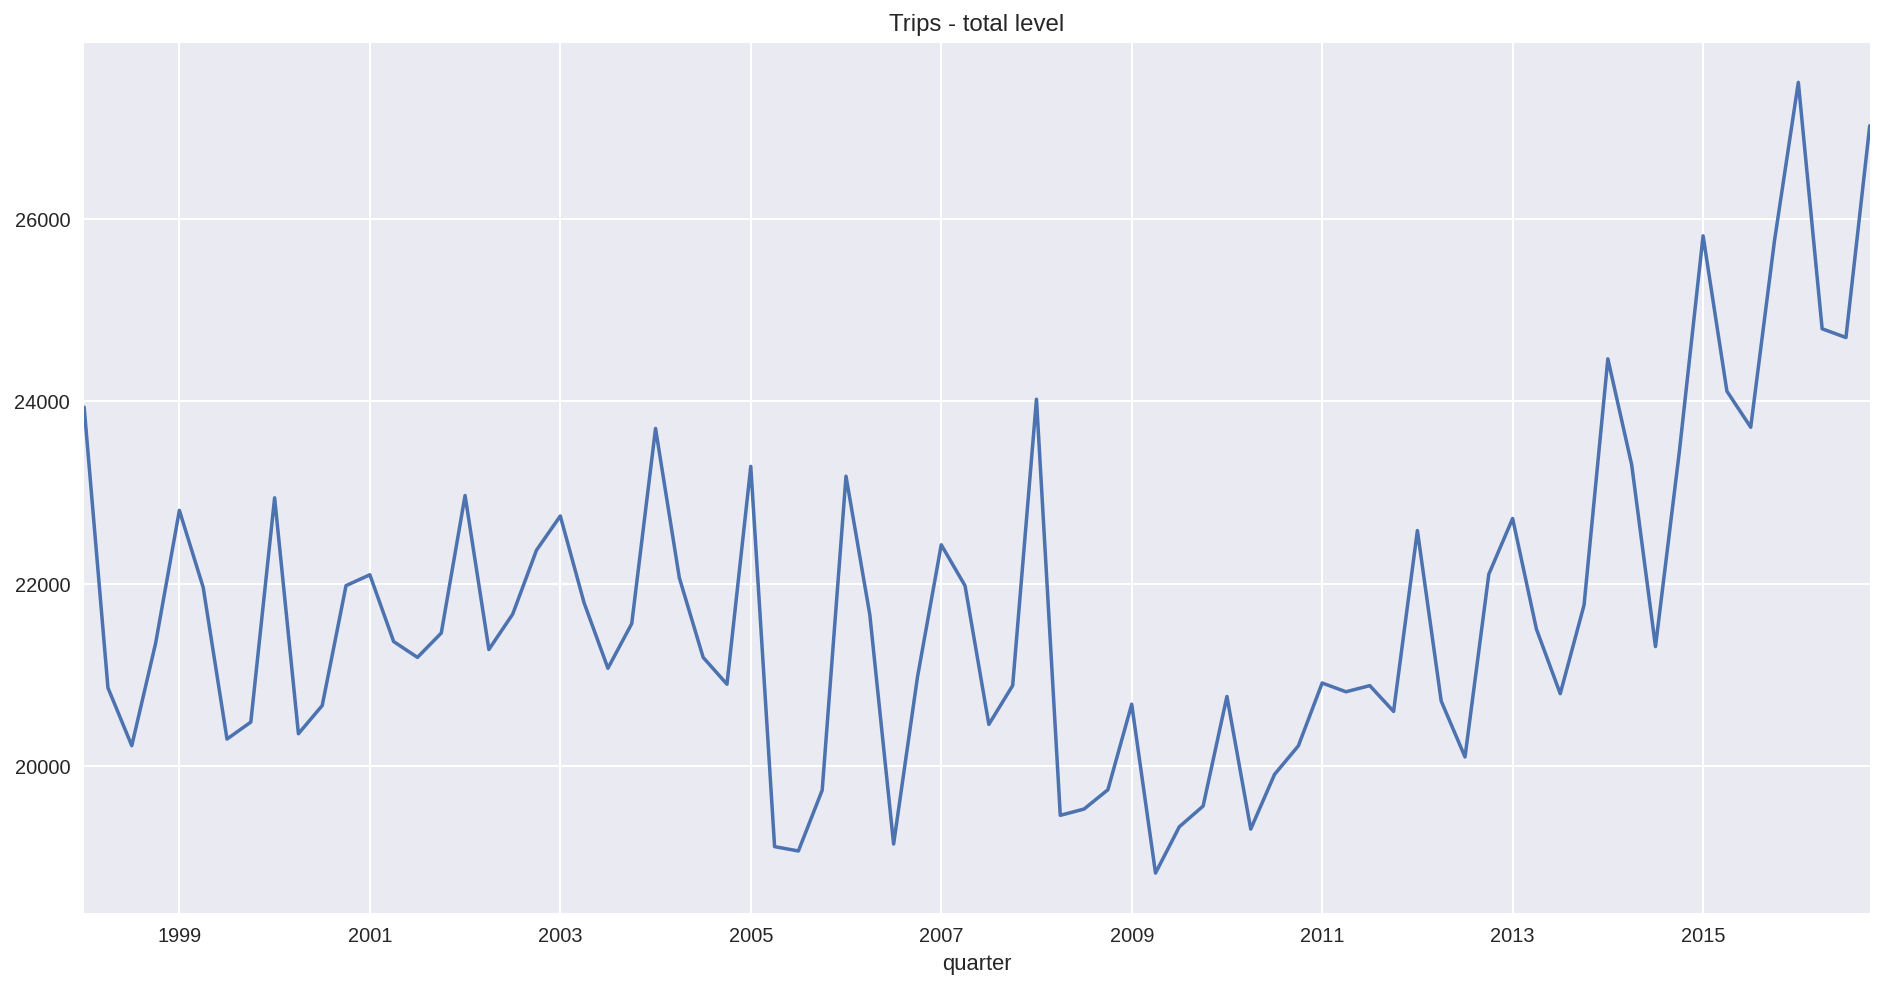

In [15]:
hierarchy_df["total"].plot(title="Trips - total level");

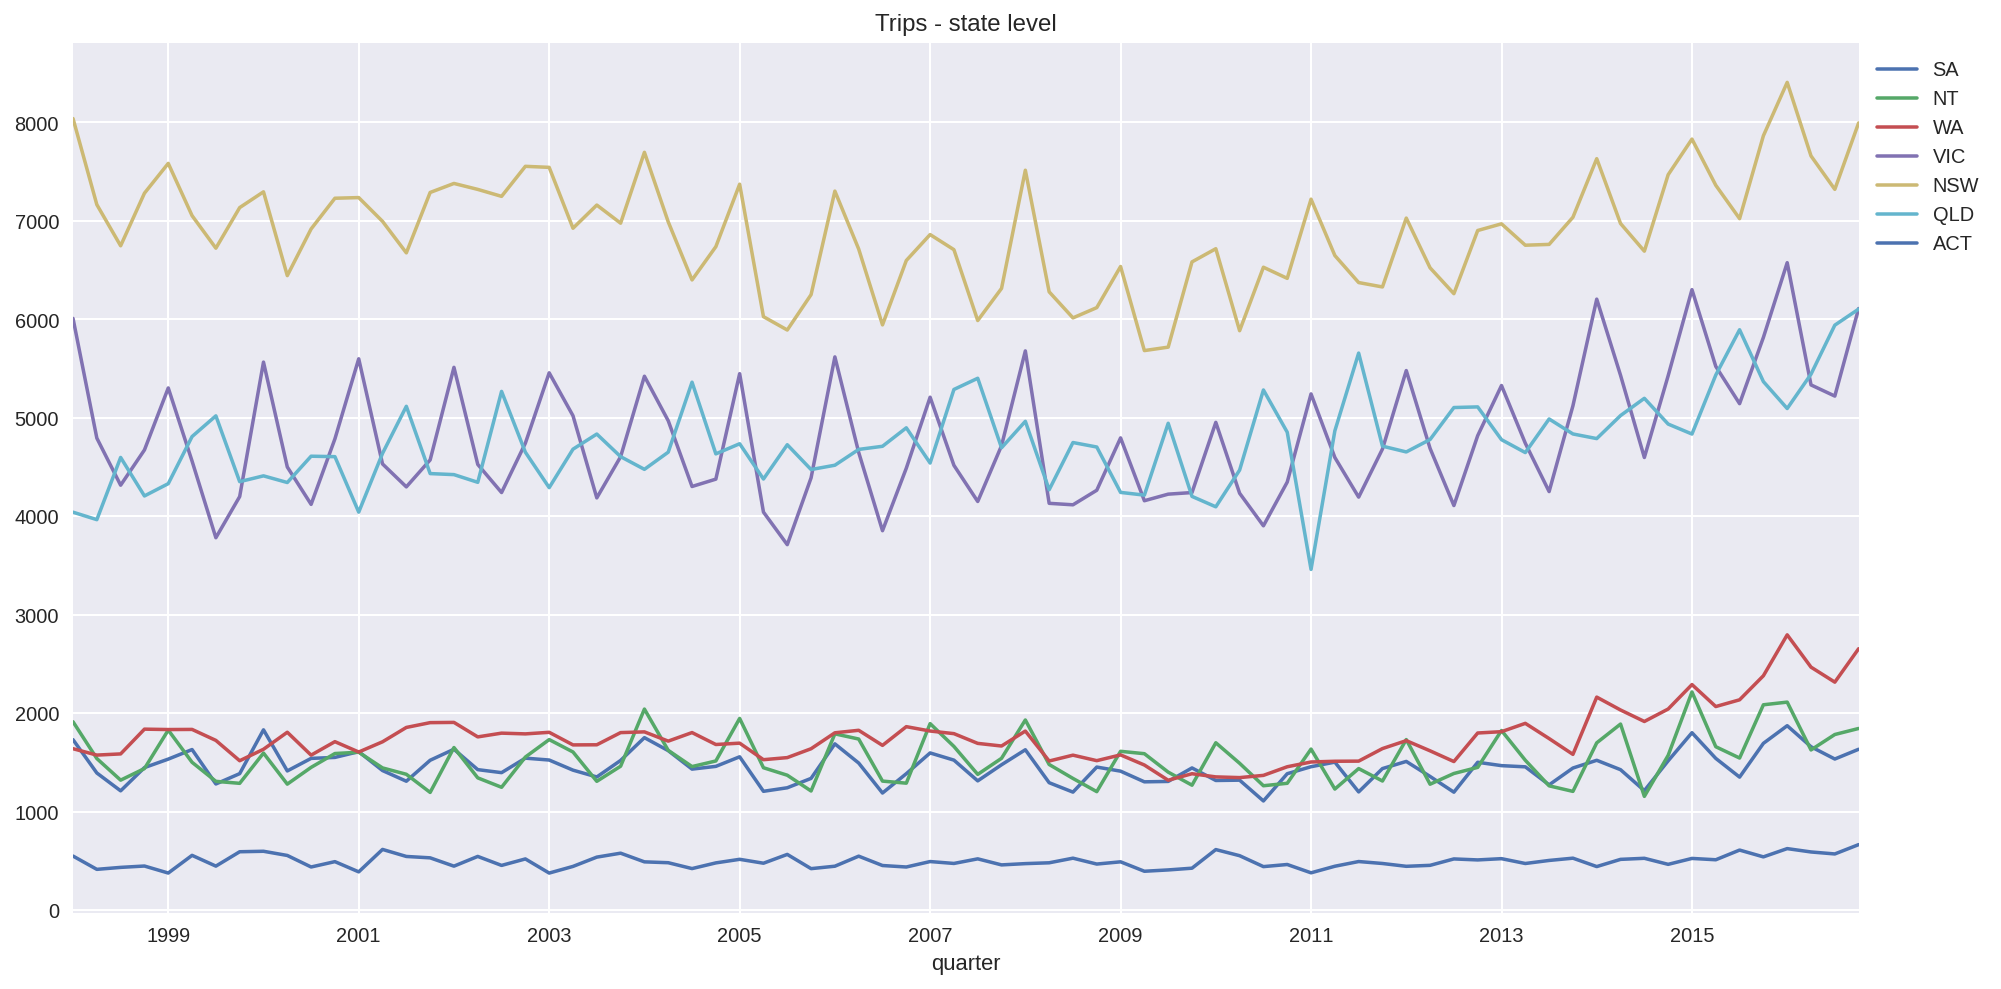

In [16]:
ax = hierarchy_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

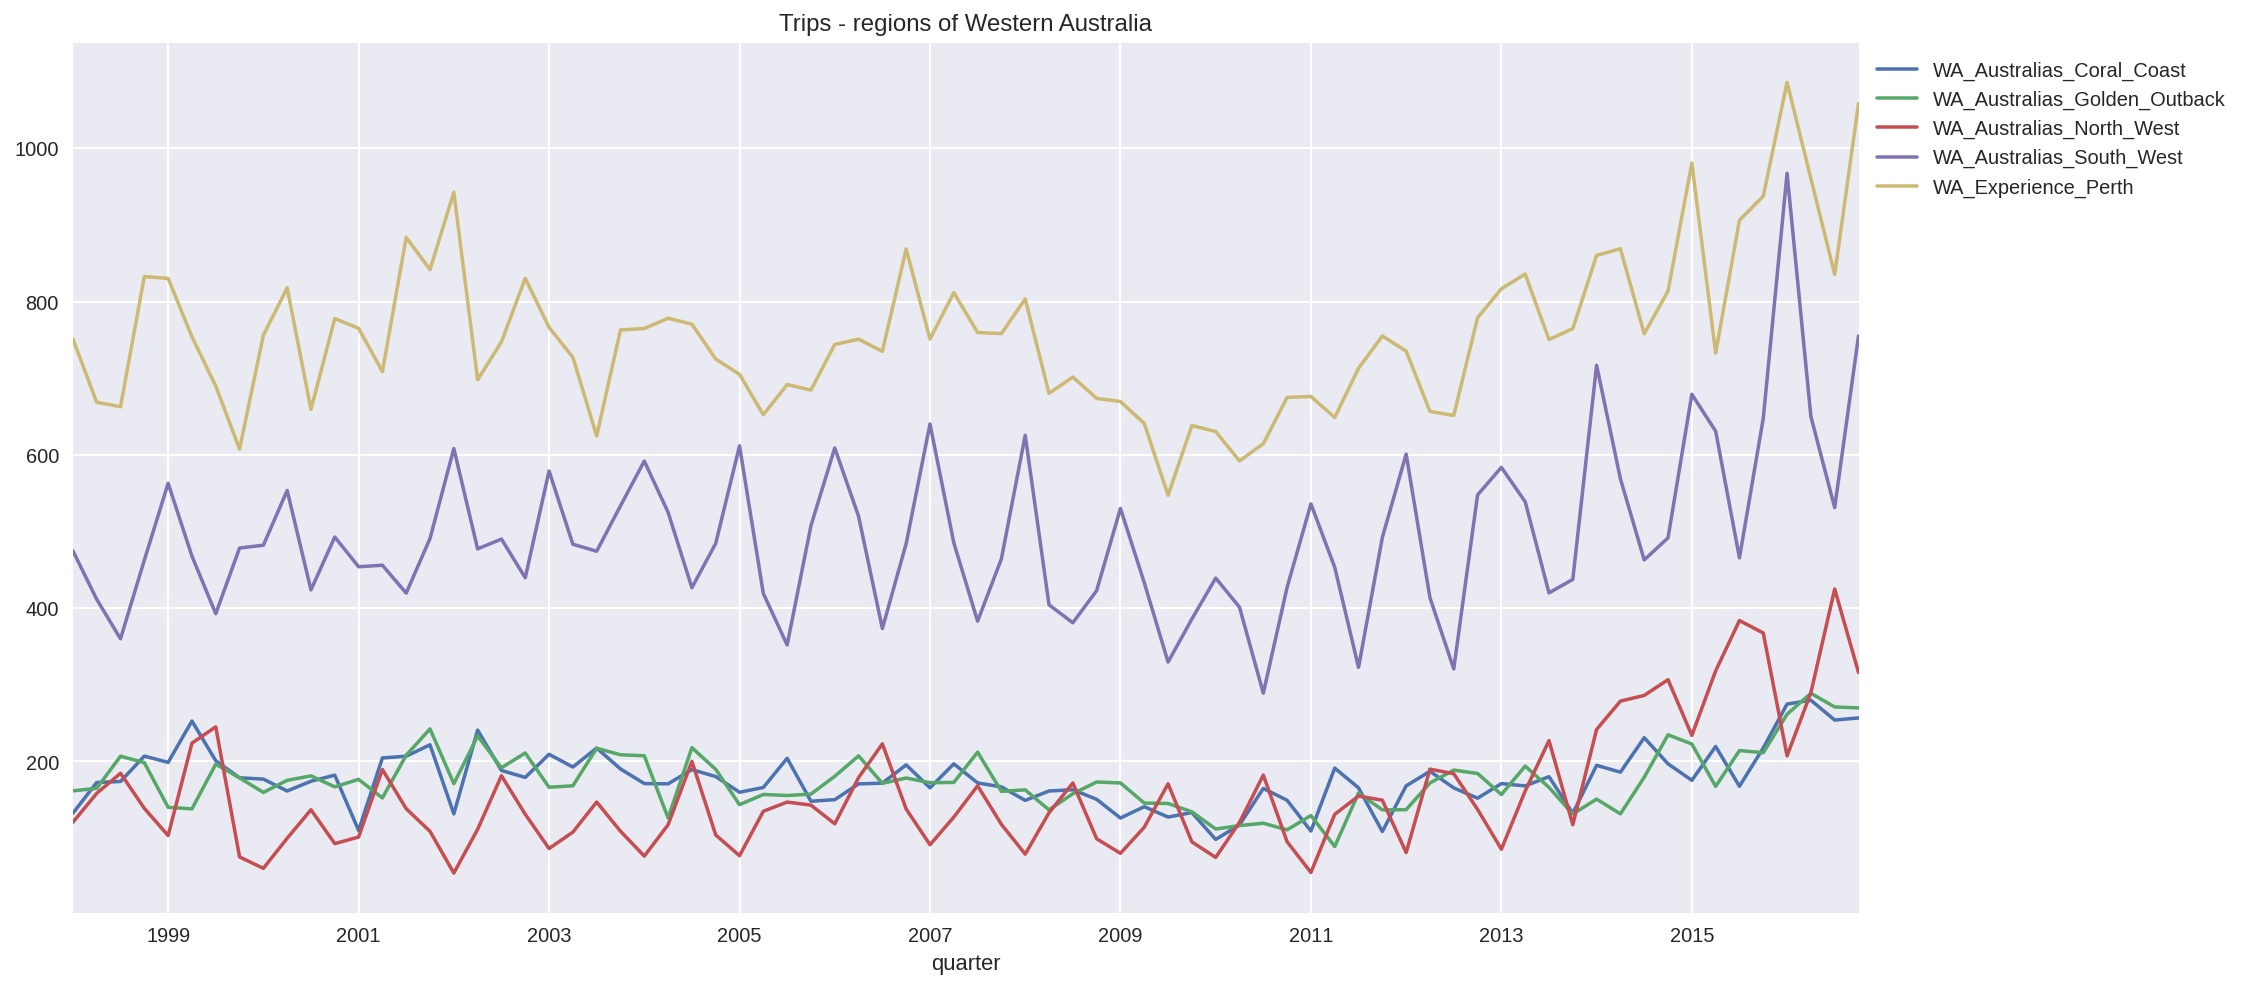

In [17]:
ax = hierarchy_df[hierarchy['WA']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));

#Hierarchical time series forecasting

In [18]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips");

#  The optimal combination using OLS


In [20]:
model_ols_sarimax = hts.HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=0)
model_ols_sarimax = model_ols_sarimax.fit(hierarchy_df, hierarchy)
pred_ols_sarimax = model_ols_sarimax.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 162.58it/s]


RMSE 21811.5929691661


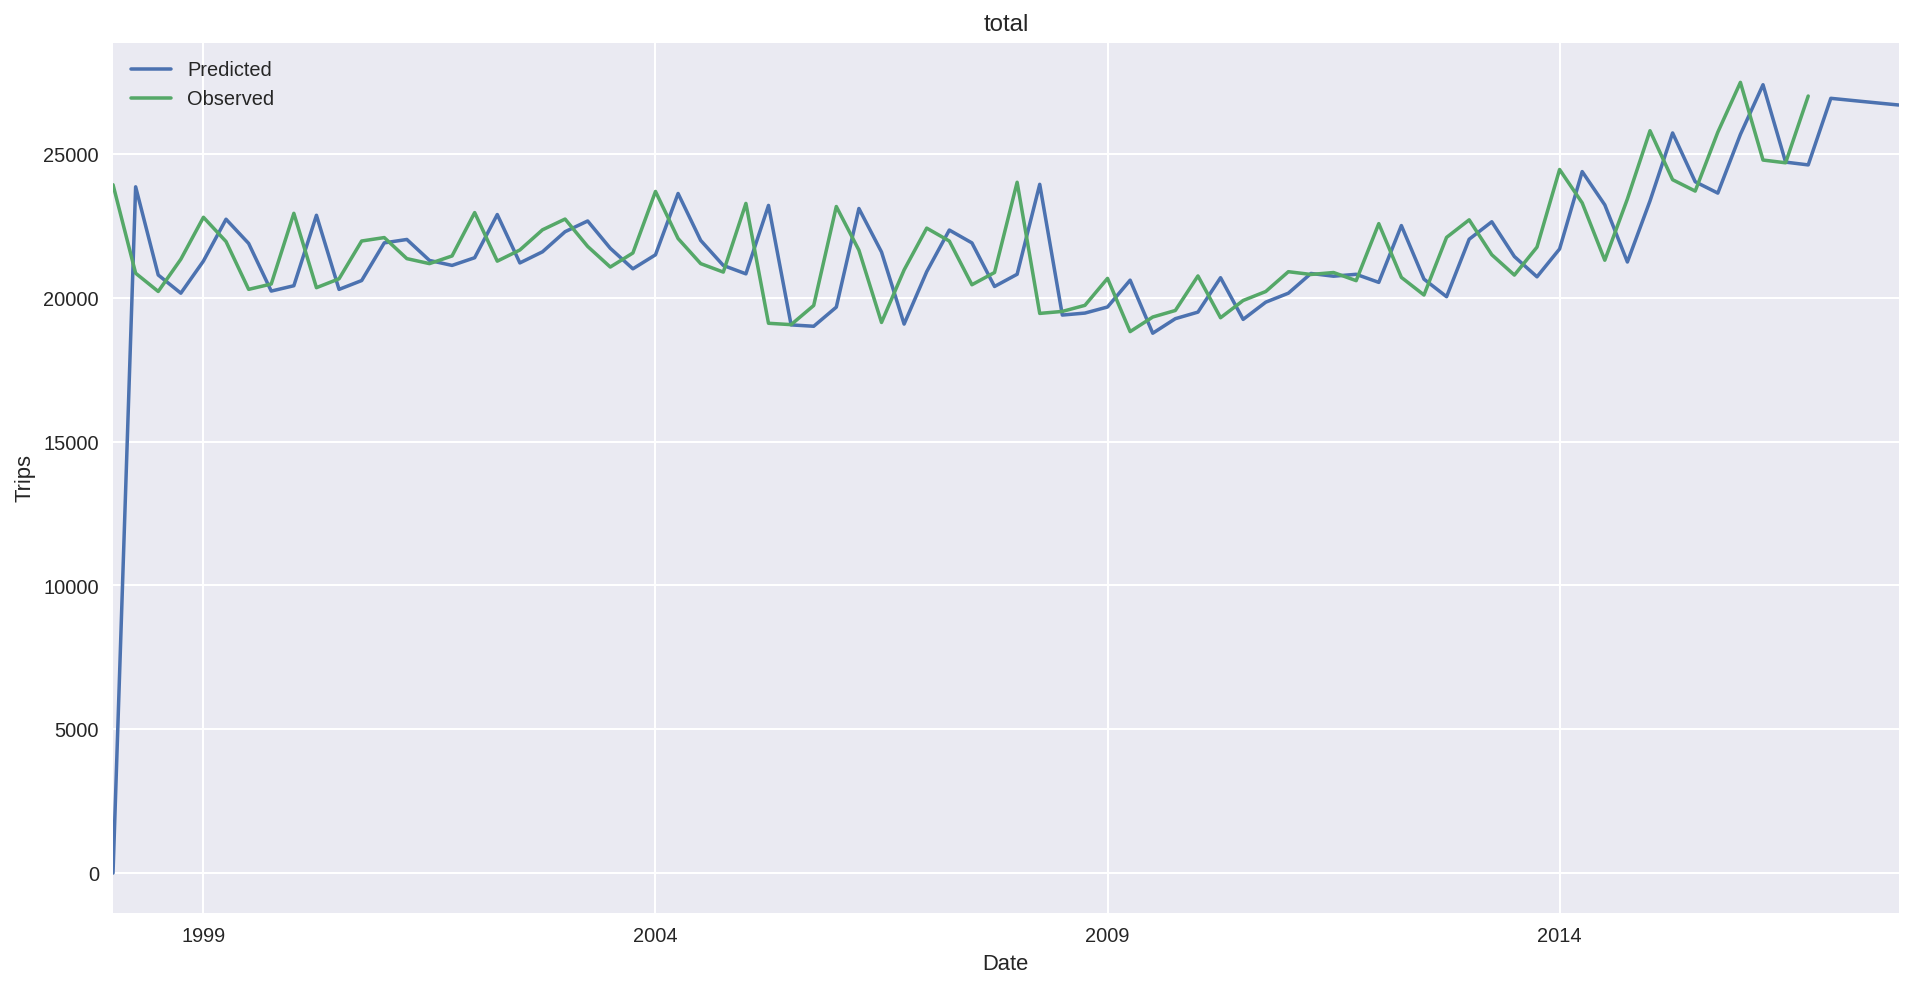

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

from statsmodels.tools.eval_measures import rmse
arr=np.array(pred_ols_sarimax.iloc[0,:])
arr1=np.array(hierarchy_df['total'])
print('RMSE',rmse(arr[:len(arr1)],arr1))

plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['total'])

RMSE 278.9994813435463


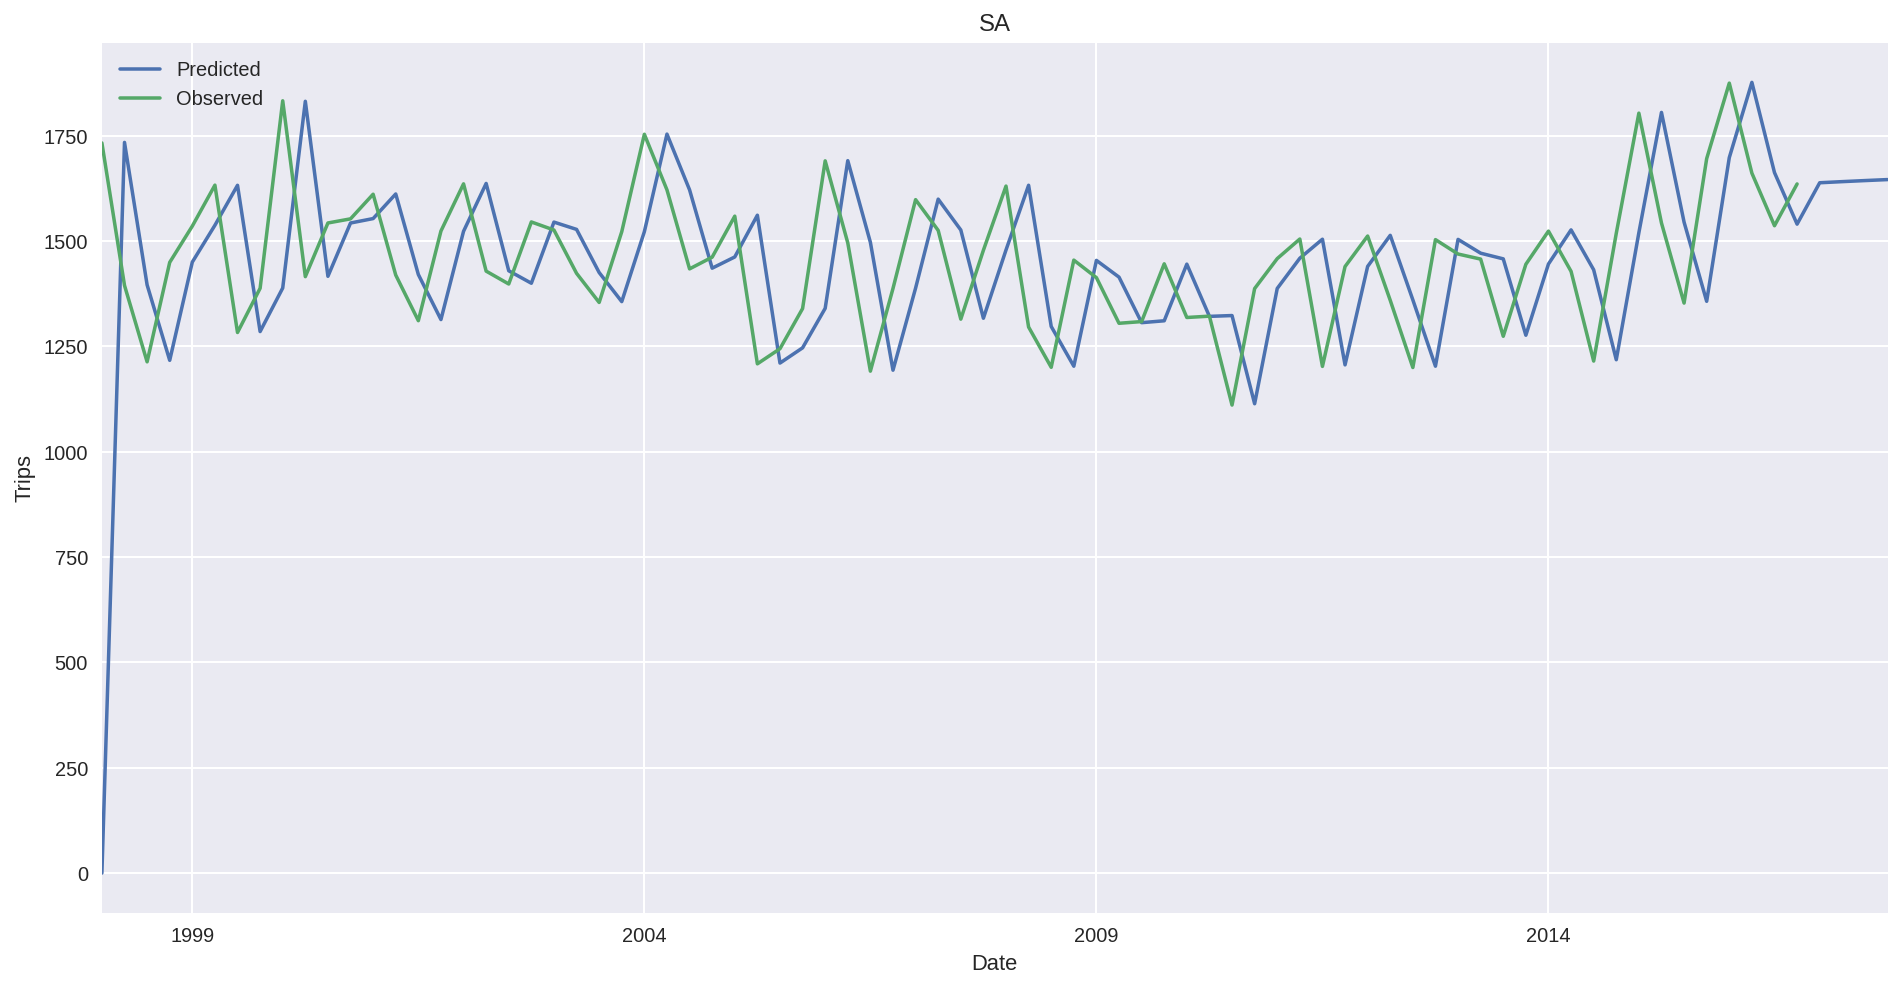

In [22]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['SA'])
arr=np.array(pred_ols_sarimax['SA'])
arr1=np.array(hierarchy_df['SA'])
print('RMSE',rmse(arr[:len(arr1)],arr1))

RMSE 17.47670763336579


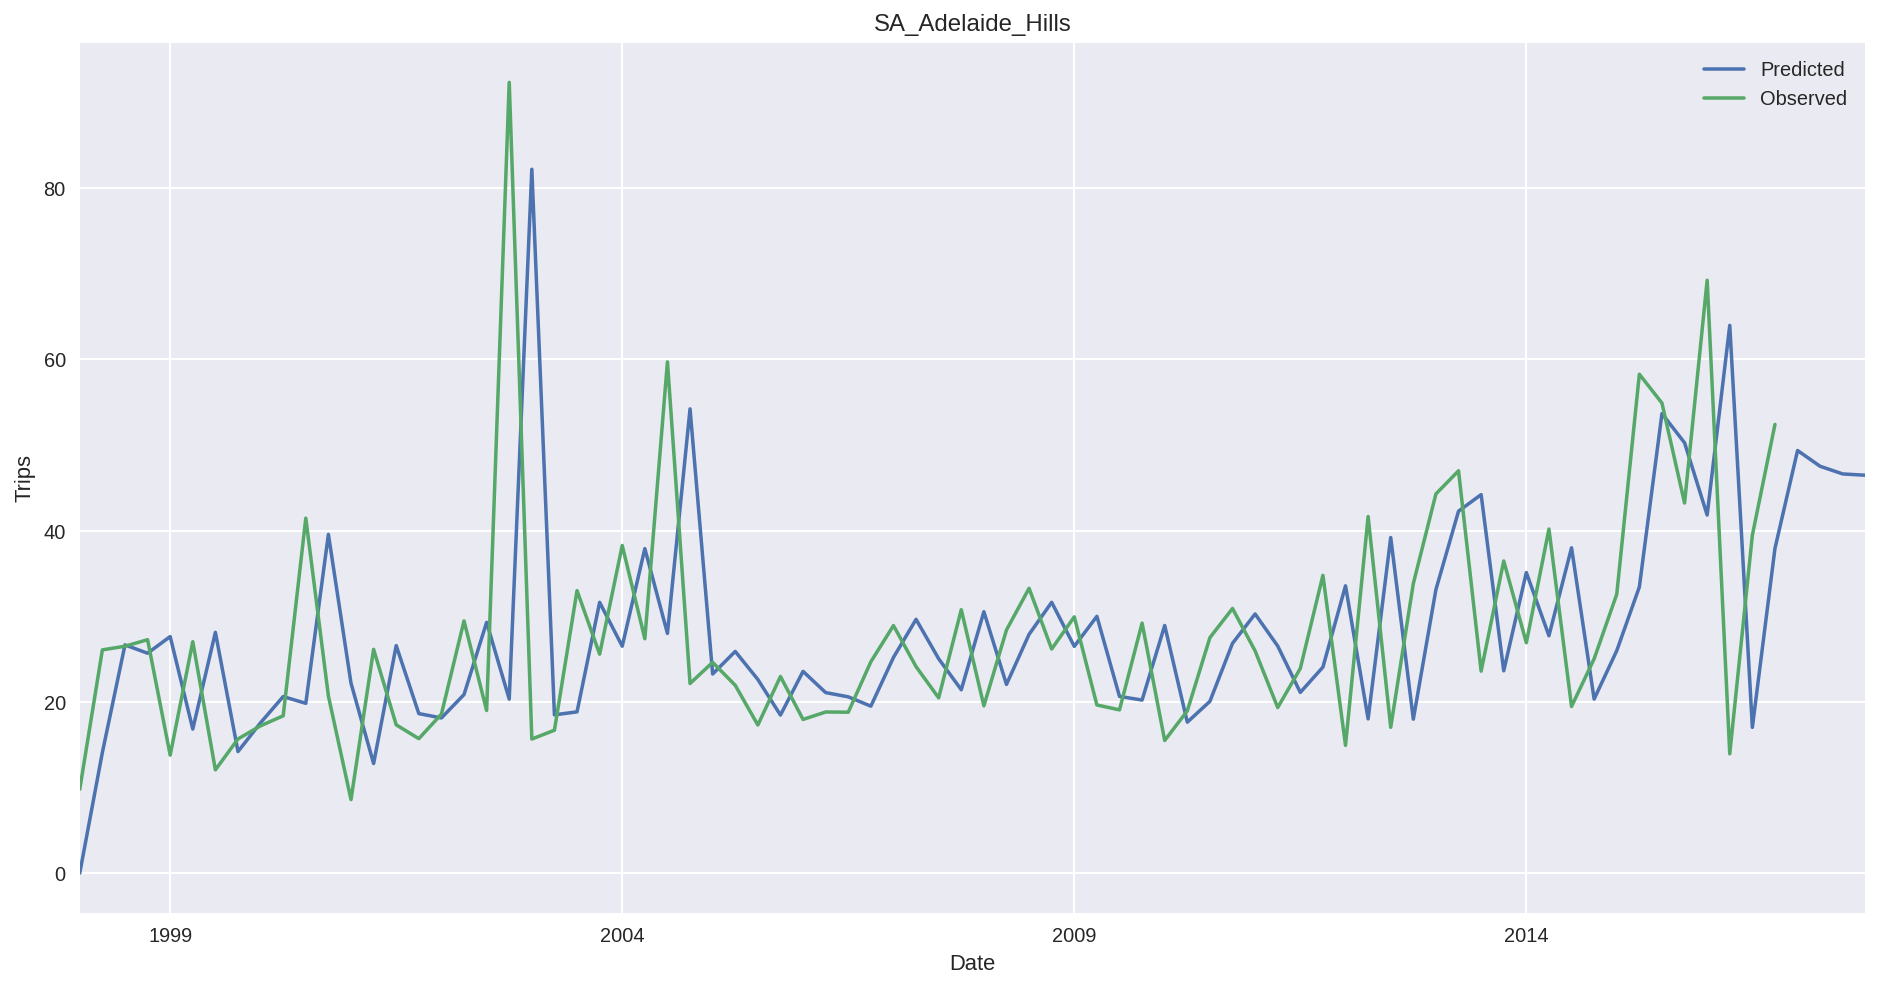

In [23]:
plot_results(pred_ols_sarimax, hierarchy_df, cols_to_plot=['SA_Adelaide_Hills'])
arr=np.array(pred_ols_sarimax['SA_Adelaide_Hills'])
arr1=np.array(hierarchy_df['SA_Adelaide_Hills'])
print('RMSE',rmse(arr[:len(arr1)],arr1))